In [1]:
import numpy as np
import os
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [2]:
embeddings_dim = 64
embeddings_path = f'data/word_embedding/twitter{embeddings_dim}.txt'

In [3]:
def load_word_embeddings(src_path):
    embeddings = dict()
    for line in open(embeddings_path, 'r', encoding = "utf-8"):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] 
        embeddings[word] = np.asarray(embedding) 
    return embeddings

embeddings = load_word_embeddings(embeddings_path) #dizionario dei word embeddings

In [5]:
conllu_dir = 'data/output_conllu/'

train_files = []
test_files = []

for filename in os.listdir(conllu_dir):
    if 'train' in filename:
        train_files.append(conllu_dir + filename)
for filename1 in os.listdir(conllu_dir):
    if 'test' in filename1:
        test_files.append(conllu_dir + filename1)

print('Documenti training set:', len(train_files))
print('Documenti test set:', len(test_files))

Documenti training set: 3977
Documenti test set: 872


In [6]:
import re

def get_digits(text):
    try:
      val = int(text)
    except:
      text = re.sub('\d', '@Dg', text) #sostituisce tutti i numeri con "@Dg" nel testo
      return text
    if val >= 0 and val < 2100: #restituisce il valore come stringa se è compreso tra 0 e 2099
      return str(val)
    else:
      return "DIGLEN_" + str(len(str(val))) #restituisce una stringa con la lunghezza del numero se è al di fuori dell'intervallo

def normalize_text(word):
    if len(word) > 26:  #restituisce "__LONG-LONG__" se la lunghezza della parola è maggiore di 26
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper():
      word = word.capitalize()
    else:
      word = word.lower()
    return word

In [7]:
#funzione per estrarre token da un file specifico 
def get_tokens_from_file(src_path):
    user_tokens = []
    lines_to_skip = 0
    take_pos = False
    for line in open(src_path, 'r', encoding = "utf-8"):
        if line[0].isdigit(): 
            splitted_line = line.strip().split('\t')
            if '-' in splitted_line[0]: 
                skip_ids = splitted_line[0].split('-')
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 
                take_pos = True 
                word = normalize_text(splitted_line[1])
                pos = splitted_line[3]
                token = {
                    'word': word,
                    'pos': pos
                }
                user_tokens.append(token)
            else:
                if lines_to_skip == 0:
                    
                    word = normalize_text(splitted_line[1])
                    pos = splitted_line[3]
                    token = {
                        'word': word,
                        'pos': pos
                    }
                    user_tokens.append(token)
                if take_pos:
                    pos = splitted_line[3]
                    user_tokens[-1]['pos'] = pos
                    take_pos = False
                lines_to_skip = max(0, lines_to_skip-1)
    return user_tokens

In [8]:
train_dataset = []

for user_path in train_files:
    user_sentences = get_tokens_from_file(user_path)
    train_dataset.append(user_sentences)

In [9]:
#calcola la media degli embeddings dell'utente
def compute_embeddings_mean(user_embeddings):
    sum_array = np.sum(user_embeddings, axis=0)
    mean_array = np.divide(sum_array, len(user_embeddings))
    return mean_array

In [10]:
#normalizza l'embedding rispetto alla norma L1
def normalize_l1(embedding):
    norm = np.sum(np.abs(embedding))
    if norm == 0:
        return embedding
    return embedding / norm

In [11]:
#calcola la media degli embeddings per tutti i token dell'utente presenti nel dizionario embeddings

def compute_all_embeddings_mean(user_tokens):
    user_embeddings = []
    
    for token in user_tokens:
        word = token['word']
        if word in embeddings:
            user_embeddings.append(embeddings[word])
    
    if len(user_embeddings) == 0:
        user_embeddings = [np.zeros(embeddings_dim)]
    
    user_embeddings = compute_embeddings_mean(user_embeddings)
    return user_embeddings

In [12]:
#normalizza gli embeddings degli utenti rispetto alla norma L1 e calcola la media

def embeddings_l1(user_tokens):
    user_embeddings = []

    for token in user_tokens:
        word = token['word']
        if word in embeddings:
            user_embeddings.append(embeddings[word])

    if len(user_embeddings) == 0:
        user_embeddings = [np.zeros(embeddings_dim)]

    user_embeddings = normalize_l1(user_embeddings)
    normalized_user_embeddings = compute_embeddings_mean(user_embeddings)
    return normalized_user_embeddings

In [13]:
#calcola la media degli embeddings per i token dell'utente filtrati per determinate parti del discorso.

def compute_filtered_embeddings_mean(user_tokens):
    user_embeddings = []
    
    for token in user_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['NOUN', 'VERB', 'PROPN', 'ADJ', 'INTJ']:
            user_embeddings.append(embeddings[word])
    
    if len(user_embeddings) == 0:
        user_embeddings = [np.zeros(embeddings_dim)]
    
    user_embeddings = compute_embeddings_mean(user_embeddings)
    return user_embeddings

In [14]:
#calcola le medie separate degli embeddings per i token dell'utente basati sulle parti del discorso

def compute_filtered_embeddings_sep_means(user_tokens):
    adj_embeddings = []
    noun_embeddings = []
    verb_embeddings = []
    propn_embeddings = []
    intj_embeddings = []
    
    for token in user_tokens:
        word = token['word']
        pos = token['pos']
        if word in embeddings and pos in ['ADJ']:
            adj_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['NOUN']:
            noun_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['VERB']:
            verb_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['PROPN']:
            propn_embeddings.append(embeddings[word])
        elif word in embeddings and pos in ['INTJ']:
            intj_embeddings.append(embeddings[word])

    if len(adj_embeddings) == 0:
        adj_embeddings = [np.zeros(embeddings_dim)]
    if len(noun_embeddings) == 0:
        noun_embeddings = [np.zeros(embeddings_dim)]
    if len(verb_embeddings) == 0:
        verb_embeddings = [np.zeros(embeddings_dim)]
    if len(propn_embeddings) == 0:
        propn_embeddings = [np.zeros(embeddings_dim)]
    if len(intj_embeddings) == 0:
        intj_embeddings = [np.zeros(embeddings_dim)]
    
    adj_embeddings = compute_embeddings_mean(adj_embeddings)
    noun_embeddings = compute_embeddings_mean(noun_embeddings)
    verb_embeddings = compute_embeddings_mean(verb_embeddings)
    propn_embeddings = compute_embeddings_mean(propn_embeddings)
    intj_embeddings = compute_embeddings_mean(intj_embeddings)
    
    #concatena tutti gli embeddings medi in un unico array
    user_embeddings = np.concatenate([adj_embeddings, noun_embeddings, verb_embeddings,
                                      propn_embeddings, intj_embeddings], axis=None) 
    return user_embeddings 

In [41]:
def extract_features(dataset):
    dataset_features = []
    for user_tokens in dataset:
        user_embeddings = compute_all_embeddings_mean(user_tokens)
        #user_embeddings = compute_filtered_embeddings_mean(user_tokens)
        #user_embeddings = compute_filtered_embeddings_sep_means(user_tokens)
        #user_embeddings = embeddings_l1(user_tokens)
        dataset_features.append(user_embeddings)
    return dataset_features

In [42]:
train_features = extract_features(train_dataset)
train_features

[array([-0.05635355,  0.01242716,  0.02034561, -0.00326281, -0.00261404,
        -0.10673566, -0.00177536, -0.0479775 , -0.0381909 , -0.00351509,
        -0.00777942,  0.08696821,  0.1018972 ,  0.04495083, -0.04849278,
         0.06026786,  0.01897148,  0.04006151,  0.1229392 , -0.04842359,
         0.00968906,  0.13312364, -0.06645688,  0.0290075 , -0.13549543,
        -0.06083725, -0.04649758,  0.02416688, -0.16980625, -0.02629316,
         0.0490499 , -0.08620557, -0.005722  ,  0.11466565,  0.00551091,
         0.06307668,  0.04305595,  0.04290568, -0.00066283,  0.05162814,
         0.05976095, -0.09111457,  0.02452097, -0.02626999,  0.05617204,
         0.00758166, -0.00632648,  0.11746119, -0.01727064,  0.07147846,
         0.06345221, -0.07827136,  0.04443253,  0.02292587,  0.06444117,
         0.04197918, -0.05299958, -0.01953189, -0.0164895 , -0.02873511,
        -0.01327366, -0.04689516,  0.00820373, -0.03478603]),
 array([-0.010512  , -0.03494033, -0.08473339, -0.06947131, -0

In [43]:
def create_label_list(list_of_files):
    labels = []
    for file_path in list_of_files:
        file_path = file_path[len('data/profiling_output/'):-len('.conllu')]
        splitted_file_path = file_path.split('_')
        label = splitted_file_path[2]
        labels.append(label)
    return labels

train_labels = create_label_list(train_files)
train_labels[:10]

['0', '1', '1', '0', '0', '0', '0', '0', '0', '1']

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_features)
# X_train = np.stack(train_features, axis=0)
X_train.shape

(3977, 64)

In [45]:
X_train

array([[0.27760479, 0.60417913, 0.49188358, ..., 0.45779581, 0.59337364,
        0.35216511],
       [0.47487992, 0.49418734, 0.24574399, ..., 0.46726698, 0.48392705,
        0.26267622],
       [0.59322564, 0.54820796, 0.4434237 , ..., 0.30124845, 0.5819516 ,
        0.306702  ],
       ...,
       [0.61521607, 0.58267813, 0.44639338, ..., 0.2178613 , 0.56127808,
        0.42076171],
       [0.43344212, 0.71615252, 0.21666229, ..., 0.73446998, 0.33179564,
        0.22231537],
       [0.43585885, 0.65974953, 0.36193657, ..., 0.51779702, 0.37724611,
        0.34417387]])

In [46]:
from sklearn.svm import LinearSVC

svc = LinearSVC(dual=False)
svc.fit(X_train, train_labels)

LinearSVC(dual=False)

In [47]:
from sklearn.metrics import classification_report

train_predictions = svc.predict(X_train)
print(classification_report(train_labels, train_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1954
           1       0.71      0.76      0.74      2023

    accuracy                           0.72      3977
   macro avg       0.73      0.72      0.72      3977
weighted avg       0.73      0.72      0.72      3977



In [48]:
y_train = np.asarray(train_labels)

In [49]:
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
folds = list(splitter.split(X_train))

for i in range(len(folds)):
    print(len(folds[i][0]), len(folds[i][1]))

3181 796
3181 796
3182 795
3182 795
3182 795


In [50]:
from sklearn.dummy import DummyClassifier

all_y_true = []
all_y_pred = []
fold_accuracies = []

for i in range(len(folds)):
    train_ids = folds[i][0]
    test_ids = folds[i][1]

    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]

    fold_X_test = X_train[test_ids]
    fold_y_test = y_train[test_ids]

    kfold_svc = LinearSVC(dual=False)
    kfold_svc.fit(fold_X_train, fold_y_train)
    fold_y_pred = kfold_svc.predict(fold_X_test)
    fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)
    fold_accuracies.append(fold_accuracy)

    dummy_clf = DummyClassifier(strategy="most_frequent")   
    dummy_clf.fit(fold_X_train, fold_y_train)
    dummy_score = dummy_clf.score(fold_X_test, fold_y_test)

    all_y_true += fold_y_test.tolist()
    all_y_pred += fold_y_pred.tolist()
    print(f"Accuracy fold {i+1}: {fold_accuracy}, baseline: {dummy_score}")

# Calcola l'accuracy media sui 5 fold
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"Accuracy media sui 5 fold: {mean_accuracy}")

Accuracy fold 1: 0.7198492462311558, baseline: 0.5062814070351759
Accuracy fold 2: 0.7035175879396985, baseline: 0.45226130653266333
Accuracy fold 3: 0.7157232704402515, baseline: 0.5031446540880503
Accuracy fold 4: 0.6918238993710691, baseline: 0.47924528301886793
Accuracy fold 5: 0.7169811320754716, baseline: 0.5069182389937107
Accuracy media sui 5 fold: 0.7095790272115293


In [51]:
test_dataset = []

for file_path in test_files:
    doc_sentences = get_tokens_from_file(file_path)
    test_dataset.append(doc_sentences)

test_labels = create_label_list(test_files)
test_features = extract_features(test_dataset)

X_test = scaler.transform(test_features)

In [52]:
test_predictions = svc.predict(X_test)
print(classification_report(test_labels, test_predictions,  zero_division=0))

              precision    recall  f1-score   support

           0       0.69      0.56      0.62       437
           1       0.63      0.75      0.68       435

    accuracy                           0.65       872
   macro avg       0.66      0.65      0.65       872
weighted avg       0.66      0.65      0.65       872



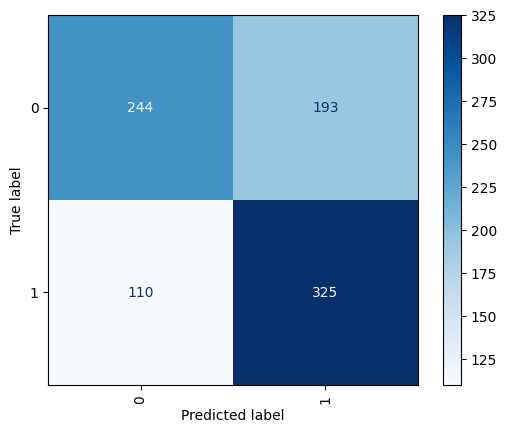

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues');